In [17]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import random

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ClassifyNet to ClassifyNet
Saving DetectNet to DetectNet
Saving akshit_sum.zip to akshit_sum.zip


In [18]:
class DetectNet(torch.nn.Module):
    def __init__(self):
        super(DetectNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,2,3,1)
        self.conv2 = torch.nn.Conv2d(2,4,3,1)
        self.conv_bn_2 = torch.nn.BatchNorm2d(4)
        self.conv3 = torch.nn.Conv2d(4,8,3,1)
        self.conv4 = torch.nn.Conv2d(8,16,3,1)
        self.conv_bn_4 = torch.nn.BatchNorm2d(16)
        self.fc1 = torch.nn.Linear(256, 64)
        self.fc2 = torch.nn.Linear(64, 1)



    def forward(self,x):
        x=self.conv1(x)
        x=torch.nn.functional.relu(x)
        x=self.conv2(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_2(x)
        x=self.conv3(x)
        x=torch.nn.functional.relu(x)
        x=self.conv4(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_4(x)
        x = torch.flatten(x, 1)
        # print("Size",x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        return x

In [19]:
class ClassifyNet(torch.nn.Module):
    def __init__(self):
        super(ClassifyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,2,3,1)
        self.conv2 = torch.nn.Conv2d(2,4,3,1)
        self.conv_bn_2 = torch.nn.BatchNorm2d(4)
        self.conv3 = torch.nn.Conv2d(4,8,3,1)
        self.conv4 = torch.nn.Conv2d(8,16,3,1)
        self.conv_bn_4 = torch.nn.BatchNorm2d(16)
        self.conv5 = torch.nn.Conv2d(16,32,3,1)
        self.conv6 = torch.nn.Conv2d(32,64,3,1)
        self.conv_bn_6 = torch.nn.BatchNorm2d(64)
        self.fc1 = torch.nn.Linear(256, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self,x):
        x=self.conv1(x)
        x=torch.nn.functional.relu(x)
        x=self.conv2(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_2(x)
        x=self.conv3(x)
        x=torch.nn.functional.relu(x)
        x=self.conv4(x)
        x=torch.nn.functional.relu(x)
        # x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_4(x)
        x=self.conv5(x)
        x=torch.nn.functional.relu(x)
        x=self.conv6(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_6(x)
        x = torch.flatten(x, 1)
        # print("Size",x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1)
        return x

In [20]:
detect_net = torch.load("DetectNet")

In [21]:
classify_net = torch.load("ClassifyNet")

In [22]:
# !unzip akshit_sum.zip
data1 = np.load('akshit_sum/data0.npy')
data2 = np.load('akshit_sum/data1.npy')
data3 = np.load('akshit_sum/data2.npy')
lab1 = np.load('akshit_sum/lab0.npy')
lab2 = np.load('akshit_sum/lab1.npy')
lab3 = np.load('akshit_sum/lab2.npy')

In [23]:
X = np.concatenate((data1,data2,data3))
Y = np.concatenate((lab1,lab2,lab3))
X = (X-0)/(255-0)

In [108]:
def detect_number(img):
  stride_height = 1
  stride_width = 1
  pixel_width=5
  max_is = []
  max_vals = []
  top_4 = []
  for j in np.arange(0,len(img[0])-28+1,stride_width):
    max_val=-1000
    max_i=-1000
    for i in np.arange(0,len(img)-28+1,stride_height):
      # plt.imshow(img[i:i+28,j:j+28])
      # plt.show()
      temp = img[i:i+28,j:j+28]

      temp = np.expand_dims(temp, 0)      # if numpy array
      temp = np.expand_dims(temp, 0)      # if numpy array
      # print(temp.shape)
      if torch.cuda.is_available():
        prob = (detect_net(torch.tensor(temp).cuda().float()))
      else:
        prob = (detect_net(torch.tensor(temp).float()))

      if(prob>max_val):
        max_val = prob.item()
        max_i = i
    
    max_is.append(max_i)
    max_vals.append(max_val)

  max_is = np.array(max_is)
  max_vals = np.array(max_vals)
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>=pixel_width):
    max_vals[max_i-pixel_width:max_i] -= 10000
  else:
    max_vals[:max_i] -= 10000


  if(max_i+pixel_width<len(max_is)):
    max_vals[max_i+1:max_i+pixel_width+1] -= 10000
  else:
    max_vals[max_i+1:] -= 10000

#############
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] -= 10000

  if(max_i>=pixel_width):
    max_vals[max_i-pixel_width:max_i] -= 10000
  else:
    max_vals[:max_i] -= 10000


  if(max_i+pixel_width<len(max_is)):
    max_vals[max_i+1:max_i+pixel_width+1] -= 10000
  else:
    max_vals[max_i+1:] -= 10000

#############
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>=pixel_width):
    max_vals[max_i-pixel_width:max_i] -= 10000
  else:
    max_vals[:max_i] -= 10000


  if(max_i+pixel_width<len(max_is)):
    max_vals[max_i+1:max_i+pixel_width+1] -= 10000
  else:
    max_vals[max_i+1:] -= 10000

#############
#############
  max_i = -1000
  max_val = -1000
  for i in range(len(max_is)):
    if(max_vals[i]>max_val):
      max_i = i
      max_val = max_vals[i]

  top_4.append([max_is[max_i],np.arange(0,len(img[0])-28+1,stride_width)[max_i]])
  max_vals[max_i] = -10000

  if(max_i>=pixel_width):
    max_vals[max_i-pixel_width:max_i] -= 10000
  else:
    max_vals[:max_i] -= 10000


  if(max_i+pixel_width<len(max_is)):
    max_vals[max_i+1:max_i+pixel_width+1] -= 10000
  else:
    max_vals[max_i+1:] -= 10000

#############
  # print(top_4)
  # for i in top_4:
  #   plt.imshow(img[i[0]:i[0]+28,i[1]:i[1]+28])
  #   plt.show()
  return top_4


In [109]:
top_4 = detect_number(X[6])

In [110]:
def get_sum(img,top_4):
  imgs = []
  for i in top_4:
    imgs.append(img[i[0]:i[0]+28,i[1]:i[1]+28])
  imgs = np.array(imgs)
  imgs = np.expand_dims(imgs, 1)      # if numpy array
  imgs = torch.tensor(imgs)
  if torch.cuda.is_available():
    imgs = imgs.cuda()
  
  preds = classify_net(imgs.float()).cpu().detach().numpy()
  sum=0
  for pred in preds:
    max_val = -10000
    max_i = -10000
    for i in range(len(pred)):
      if max_val <pred[i]:
        max_val = pred[i]
        max_i = i 
        # print(i)
    
    sum+=max_i
    # print(max_i)
  return sum
  # print(imgs.shape)

In [111]:
get_sum(X[6],top_4)

12

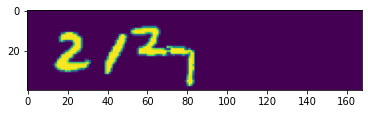

In [112]:
plt.imshow(X[6])

In [119]:
accs = 0
for i in range(1000):
  top_4 = detect_number(X[i])
  ans = get_sum(X[i],top_4)
  if(ans == Y[i]):
    accs+=1
  if(i%100==0):
    print("i=",i)
print("Accuracy:",accs/1000)

i= 0
i= 100
i= 200
i= 300
i= 400
i= 500
i= 600
i= 700
i= 800
i= 900
Accuracy: 0.096
